In [3]:
import joblib
import cv2
import numpy as np
from skimage.feature import hog
import os

In [4]:
def extract_features(image_path):
    img = cv2.imread(image_path, 0)  # Read the image in grayscale
    img = cv2.resize(img, (64, 64))  # Resize image to 64x64
    
    # Threshold and blur for better contours
    img = cv2.GaussianBlur(img, (3, 3), 0)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Hu Moments
    moments = cv2.moments(thresh)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)  # Log scale for better range

    # HOG Features
    hog_feat = hog(thresh, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

    return np.hstack([hu, hog_feat])


In [5]:
model = joblib.load('svm_model.pkl')
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')


In [6]:
def test_all_images(test_dir):
    true_labels = []
    predictions = []
    
    # Loop through all classes and images
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if it's an image file
                    # Extract features from the image
                    features = extract_features(image_path)
                    features_scaled = scaler.transform([features])  # Apply scaling
                    features_pca = pca.transform(features_scaled)  # Apply PCA transformation
                    
                    # Make prediction
                    prediction = model.predict(features_pca)
                    
                    # Collect the true label and predicted label
                    true_labels.append(class_name)
                    predictions.append(prediction[0])

    return true_labels, predictions



In [7]:
test_directory = '/home/udbhav-purwar/Documents/Project/Airista/Shapes-DS/test'


In [8]:
true_labels, predictions = test_all_images(test_directory)


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(true_labels, predictions))



Classification Report:
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00       744
      square       1.00      1.00      1.00       753
        star       1.00      1.00      1.00       753
    triangle       1.00      1.00      1.00       744

    accuracy                           1.00      2994
   macro avg       1.00      1.00      1.00      2994
weighted avg       1.00      1.00      1.00      2994



Confusion Matrix:


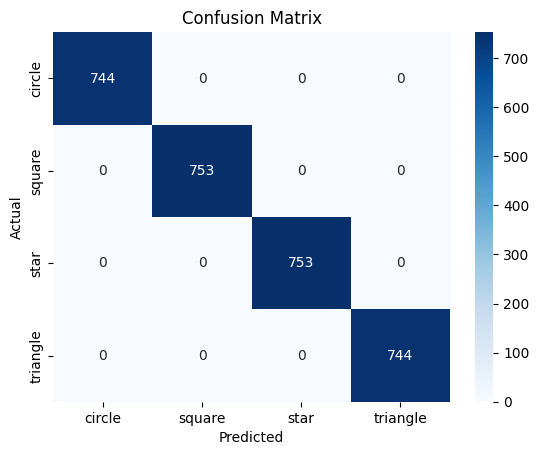

In [10]:
print("Confusion Matrix:")
cm = confusion_matrix(true_labels, predictions)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
